# Parametric Liquid Engine Maker for OpenRocket
This is adapted from a script created by natronics, 7deeptide, and jalouke to create engine files for OpenRocket. Its original purpose was to determine some crucial properties of the engine system based on initial assumptions and specifications a few years before the multidisciplinary design optimization for LV4 began.

It has since been reformed to take its parameters from the optimization in order to utilize OpenRocket as a downstream verifier of potential designs, since the optimizer's internal model of aerodynamics is particularly low-fidelity. In addition, since this script is imported by our trajectory model and optimizer, we may define certain functions, variables, and parameters in one location. This eliminates redundancy and makes our lives easier if we would like to change any of our parameters based on improved assumptions or information.

## Assumptions
* Using OpenRocket is the correct way to decide whether a given design is viable.
* The upstream process that determines our variables does not provide garbage.
* There is already a corresponding rocket file that is appropriately matched to the engine file we create.
* Oxygen/Fuel ratio is 1.3 to 1.
    * This has been determined using CEArun, based on our assumptions (found in optimization notebook) about chamber thermodynamics.
* 10% of tank length should be added to account for ullage (tanks not filling to ideal capacity).
* Factor of safety for tank stress is 2.
* Mass fudge factor for system components is 2.
* Gaps between subsystems are 0.05 meters.
* Oxygen tank is aluminum and fuel tank is carbon-fiber.
* Mass of EFS is 10 kg and includes plumbing.
* Mass of EMS is 1 kg.
* Mass of LFE is 3 kg.
* Length of EFS subsystem is 18 in.
* Length of EMS subsystem is 4 in.
* Length of LFE subsystem is 0.3 meters.
* Distance between interior of airframe and exterior of a tank is 0.007 meters (measured from LV3).
* Tank pressure is ~100 PSI, and is pressurized by an N2 tank and ramped up by the EFS prior to injection.
* Bulkheads (in gaps between subsystems) are 0.25 in thick, cylindrical, aluminum, and 60% empty space.
* The differences of vectors of burn times, thrust values, and altitudes between OpenRocket and the trajectory simulation that generates OpenRocket's engine file are negligible.
    * Both models have the same burn times.
    * Both models have the same thrust curves with respect to time.
    * Thrust at a time is actually a function of altitude at that time.
    * Altitudes differ between the two models to an extent determined by time step and fidelity of numerical integration.
        * For the fast Runge-Kutta with $\Delta t = 0.25$, our integration results in a peak altitude ~1-3 km below OpenRocket.
        * For the medium Runge-Kutta with the same time step, our peak altitude has been no more than 200 m of OpenRocket, but this increased accuracy is no longer conservative and much slower to compute, so we continue to use the low-fidelity trajectory.
        * A final caveat is that a rigorous analysis of our trajectory model is still incomplete.

## Parameters, Variables, and Utility Functions
This block is self-explanatory, and where it is not, there are in-line comments.

In [1]:
%run inputs.ipynb
rkt_prefix = "../rocket_farm/" # the rockets live on a cute little farm upstate where they frolic in fields

## Utility Functions
# unpack rocket template temporarily
def unzip():
    with ZipFile('../psas_rocket.ork') as myzip:
        myzip.extract('rocket.ork')

# package our new rocket and remove temporary template
def zipit(index):
    with ZipFile(rkt_prefix+'psas_rocket_'+index+'.ork', 'w') as myzip:
        myzip.write('rocket.ork')
    if 'linux' in _platform:
        os.system('rm rocket.ork')
    elif "darwin" in _platform:
        os.system('rm rocket.ork')
    elif "win" in _platform:
        os.system('del rocket.ork')

# pulls ALL file references from given directory
def all_files(directory):
    for path, dirs, files in os.walk(directory):
        for f in sorted(files):
            yield os.path.join(path, f)

# counts how many rockets are in our directory and then increments by 1
def get_index():
    ork_files = [f for f in all_files(rkt_prefix)
                   if f.endswith('.ork')]
    return len(ork_files) + 1

## Tank and System Geometry and Physics
I will explain the proportion function algebraically.

'A' is the total amount, 'O' is the proportion that is LOX, 'F' is the proportion that is IPA/H2O.
$$A = O + F$$
$$\frac{O + F}{F + O} = \frac{A}{F + O} = 1$$
$$\frac{O}{F + O} + \frac{F}{F + O} = 1 \space\space\space(*)$$
$$\frac{F}{F}\frac{\frac{O}{F}}{1 + \frac{O}{F}} + \frac{F}{F}\frac{1}{1 + \frac{O}{F}} = 1$$
$$\frac{\frac{O}{F}}{1 + \frac{O}{F}} + \frac{1}{1 + \frac{O}{F}} = 1$$
$$O = A\frac{\frac{O}{F}}{1 + \frac{O}{F}}$$ 
$$F = A\frac{1}{1 + \frac{O}{F}}$$ 
These last two identities should be clear to see from the starred equation, and the preceding lines are to demystify all the fractions.

The upstream optimization doesn't account for the distinction between the radius of the airframe and of the propellant tank, so we do that here.

Because the radius of a tank changes while the mass and density of its contents remain constant, we must derive a new length so that its volume is unchanged.
$$Area = \pi r^2$$
$$Volume = \frac{m}{\rho}$$
$$Length = \frac{Volume}{Area}$$

The upstream optimization does not account for there being two separate tanks with different requirements, so we do that here. After proportioning the propellant masses and determining the tank radii, we determine the length of each tank based on the mass and density of its contents. For a layer of realism, we add a percentage to the tank lengths to account for our inability to perfectly pack a tank without wasted space.

To be clear, *tank_thickness* is engineering black magic and beyond my understanding. I have changed it to account for a different tank pressure than the original MDO assumed. Nowhere do we account for the difference in volume that the inner radius entails, but this is hopefully a small change that is absorbed by the assumptions regarding ullage and factors of safety. It would be relatively trivial to account for that difference explicitly in *split_tanks* if we did some elementary arithmetic. If someone asks politely, I'll do it. *tank_mass* is more engineering black magic but straight-forward; its just a uniformly dense thicc cylinder with lids, and the estimate is doubled for good pessimism.

Georges demanded I account for the mass of bulkheads in the gaps between subsystems, so we made up a rough estimate of how heavy they might be based off our guesses about their geometry.

Be aware that *split_tanks*, *system_length*, and *system_mass* are used heavily by the upstream optimization and trajectory simulation where the fine detail is necessary. The airframe diameter and original total tank length are pretty much just used to determine the volume and thus total propellant mass.

In [2]:
# length of tank based on its inner radius, and mass and density of contents
def tank_length(m, rho, r):
    return m / (rho * pi * r**2)

# Total length of engine system
def system_length(l_o, l_f):
    return sum([l_o, l_f, l_feed, l_ems, l_engine, 0.152]) # plus pass through

## Engine System Dynamics
This is a nice picture from some previous work that gives an idea of what the next code block accounts for. 

Basically, we will eventually hand OpenRocket a black box for an engine system that will account for its own center of mass as well as changes in that. I don't believe these equations require explanation, they're just ugly routine computations, but if asked I will provide further detail. There may be a prettier way of writing this code that involves less eye-bleeding, but I'm fairly sure it's correct.

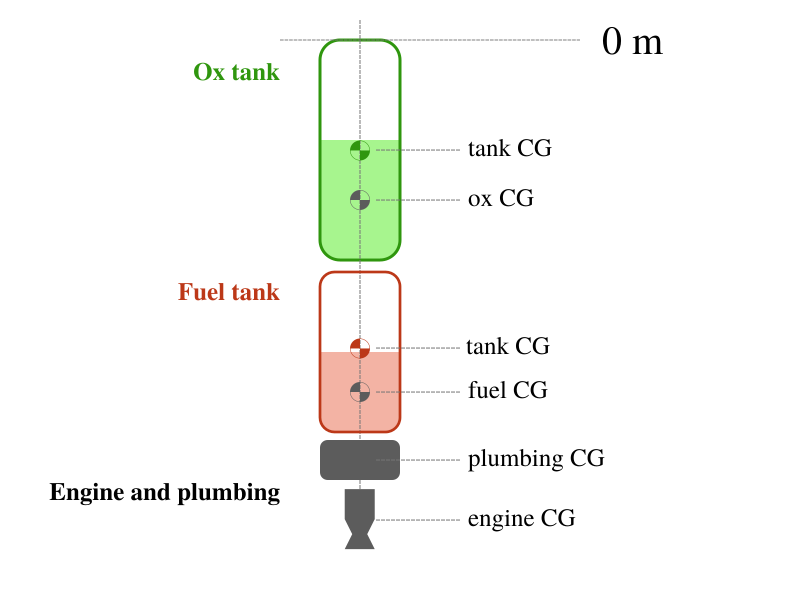

In [3]:
from IPython.display import SVG
SVG(filename='../archive/motor-system.svg')

In [4]:
# For openrocket thrust Curve, since the mass and cm change over time.
# dry center of mass of engine system, note these are positions not lengths
def dry_c_of_m(l_o, l_f, m_tank_o, m_tank_f, system_mass):
    # fuel tank cm is in the center of the tank
    cm_tank_f  = l_f / 2.0
    cm_passthru= l_f + 0.152/2
    # next tank down (lox)
    cm_tank_o  = l_f + 0.152 + (l_o/2.0)
    # now feedsystem
    cm_feed    = l_f + 0.152 + l_o + (l_feed/2.0)
    #ems
    cm_ems     = l_f + 0.152 + l_o + l_feed  + (l_ems/2.)
    # finally the engine
    cm_engine  = l_f + 0.152 + l_o + l_feed + l_ems  + (l_engine/2.0)
    
    # get center of mass
    dry_cm = sum([cm_tank_f*m_tank_f, cm_tank_o*m_tank_o, cm_feed*m_feed, cm_ems*m_ems, cm_engine*m_engine]) 
    dry_cm /= system_mass
    return dry_cm

# Total center of mass (including propellants) at a specific time
def c_of_m(dry_cm, dry_mass, r, l_o, l_f, prop_mass):
    # propellant masses
    m_o, m_f = proportion(prop_mass, OF)
    
    #accounts for gravity pushing each propellent to bottom of its tank
    cm_f_l = l_f - tank_length(m_f, IPA['rho'], r)/2.0
    cm_o_l = l_f + 0.152 + l_o - tank_length(m_o, LOX['rho'], r)/2.0
    
    weighted_cm_prop = m_f*cm_f_l + m_o*cm_o_l
    return (dry_cm*dry_mass + weighted_cm_prop) / (dry_mass + m_f + m_o)

### File IO
Our optimization will spit out a list of relevant details, which is passed to this function so we can save everything potentially useful in one nice way.

Our rocket template is an xml file set to use one node to determine the diameter of each subsystem so we just have to climb that tree to change out the airframe radius and the two tank lengths and viola! Note, this effects just the rocket file, it is the next function that creates the engine file.

There is probably a nice way to use the imported XML library instead of the code from the previous MDO, but I don't quite care enough since it's perfectly functional. This takes its parameters straight from the trajectory simulation of an optimized rocket. It doesn't do anything particularly exciting, just creates a thrust curve and calculates some odds and ends that OpenRocket likes. It's unfortunate that thrust in OpenRocket doesn't account for altitude, but the discrepancy in final apogee is usually no more than 2 or 3 km (our trajectory simulation seems to be conservative).

Be aware that I have not yet tested this in Windows or MACOSX, or outside of Ubuntu 18 for that matter.

In [5]:
# Takes rocket properties from optimized trajectory and creates a list of all relevant properties
def print_characteristics(mdot, prop_mass, l_o, l_f, index, res_text):
    res_text.append("\n")
    res_text.append("\nENGINE SYSTEM DETAILS")
    res_text.append("\n-----------------------------")
    # Mass flow for each propllent
    mdot_o, mdot_f = proportion(mdot, OF)
    res_text.append("\nOx flow: . . . . . . . . . . %7.3f kg/s" % mdot_o)
    res_text.append("\nFuel flow:                   %7.3f kg/s" % mdot_f)
    
    # Propellent Mass for each propllent
    mprop_o, mprop_f = proportion(prop_mass, OF)
    res_text.append("\nOx mass: . . . . . . . . . . . %5.3f kg" % mprop_o)
    res_text.append("\nFuel mass:                     %5.3f kg" % mprop_f)
    
    # dimensions of each tank
    res_text.append("\nOx tank length + ullage:      %7.3f m" % l_o)
    res_text.append("\nFuel tank length + ullage:    %7.3f m" % l_f)
    
    # create a file with all this info in it
    with open(rkt_prefix+'psas_rocket_'+index+'_traj.txt', 'w') as traj:
        for line in res_text:
            traj.write(line)

# create a rocket file for our engine's dimensions and characteristics
def update_body(index, out_r, l_o, l_f):
    unzip() # unpack template
    
    with open('rocket.ork', 'rb') as xml_file:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for child in root.iter():
            #set radius, this node propagates itself in openrocket
            for kid in child.iterfind('aftradius'):
                kid.text = str(out_r)
            for kid in child.iterfind("*[name='Fuel Tank']"):
                kid.find('length').text = str(l_f) # set fuel tank length
            for kid in child.iterfind("*[name='LOX Tank']"):
                kid.find('length').text = str(l_o) # set lox tank length
        tree.write('rocket.ork')

    zipit(index) # repack template
    print("New rocket generated from template!")

# when a father engine and a mother engine love each other very much...
# they make an openrocket engine 
# that is approximately equivalent to the trajectory profile from the optimimization
def make_engine(mdot, prop_mass, Thrust,
                inr_radius, thickness,
                l_o, l_f, m_tank_o, m_tank_f,
                Burn_time, Isp, res_text, sys_mass, CoM):
    
    index = str(get_index())
    
    #print_characteristics(mdot, prop_mass[0], l_o, l_f, index, res_text)
    
    radius = inr_radius + thickness
    length = system_length(l_o, l_f)
    eng_sys_dry_mass = sys_mass
    #eng_sys_dry_mass = sum([m_tank_o, m_tank_f, m_feed, m_ems, m_engine])
    dry_cm = dry_c_of_m(l_o, l_f, m_tank_o, m_tank_f, eng_sys_dry_mass)
    
    n = len(Thrust)
    peak = max(Thrust)
    average = float(sum(Thrust) / n)
    
    file_head = """<engine-database>
  <engine-list>
    <engine  mfg="PSAS" code="{code}" Type="Liquid" dia="{diameter}" len="{length}"
    initWt="{total_mass}" propWt="{M_prop}" delays="0" auto-calc-mass="0" auto-calc-cg="0"
    avgThrust="{a_thrust}" peakThrust="{p_thrust}" throatDia="0." exitDia="0." Itot="{impulse}"
    burn-time="{burn_time}" massFrac="{m_frac}" Isp="{Isp}" tDiv="10" tStep="-1." tFix="1"
    FDiv="10" FStep="-1." FFix="1" mDiv="10" mStep="-1." mFix="1" cgDiv="10"
    cgStep="-1." cgFix="1">
    <comments>Optimized engine</comments>
    <data>
""".format(**{'code': 'PSAS '+index,
              'diameter': radius*2*1000,
                  'length': length*1000,
                  'total_mass': (prop_mass[0] + eng_sys_dry_mass)*1000,
                  'M_prop': prop_mass[0]*1000,
                  'a_thrust': average,
                  'p_thrust': peak,
                  'burn_time': Burn_time,
                  'm_frac': eng_sys_dry_mass/(eng_sys_dry_mass + prop_mass[0]),
                  'impulse': average*Burn_time,
                  'Isp': Isp,
        })
    
    data = [] # this is going to be our thrust curve!
              # may be slightly inaccurate if/when altitudes vary between trajectory.py and openrocket
    resolution = float(Burn_time/n) # sec per step
    for i in range(n):
        data.append('     <eng-data  t="{t}" f="{thrust}" m="{mass}" cg="{cg}"/>\n'.format(**{
            't': i * resolution, # sec
            'thrust': Thrust[i],
            'mass': (eng_sys_dry_mass + prop_mass[i]) * 1000,
            'cg': CoM[i] * 1000,
            #'cg': c_of_m(dry_cm, eng_sys_dry_mass, inr_radius, l_o, l_f, prop_mass[i]) * 1000,
        }))
    
    file_tail = """
    </data>
  </engine>
</engine-list>
</engine-database>"""
    
    # we're gonna put the engine file in the default location
    prefix = "./"
    if 'linux' in _platform:
        home = os.path.expanduser("~")
        prefix =  os.path.join(home, '.openrocket/ThrustCurves/')
    elif "darwin" in _platform:
        home = os.path.expanduser("~")
        prefix =  os.path.join(home, 'Library/Application Support/OpenRocket/ThrustCurves/')
    elif "win" in _platform:
        home = os.getenv("APPDATA")
        prefix = os.path.join(home, "OpenRocket/ThrustCurves/")
    
    if not os.path.isdir(prefix):
        os.mkdirs(prefix) # in case openrocket not installed to prevent crash
        
    # now write the file, great job!
    with open(os.path.join(prefix, 'psas_motor_'+index+'.rse'), 'w') as eng:
        eng.write(file_head)
        for d in data:
            eng.write(d)
        eng.write(file_tail)
        
    update_body(index, radius, l_o, l_f) # make a rocket to correspond with our new engine
    print("Reopen OpenRocket to run simulation.")